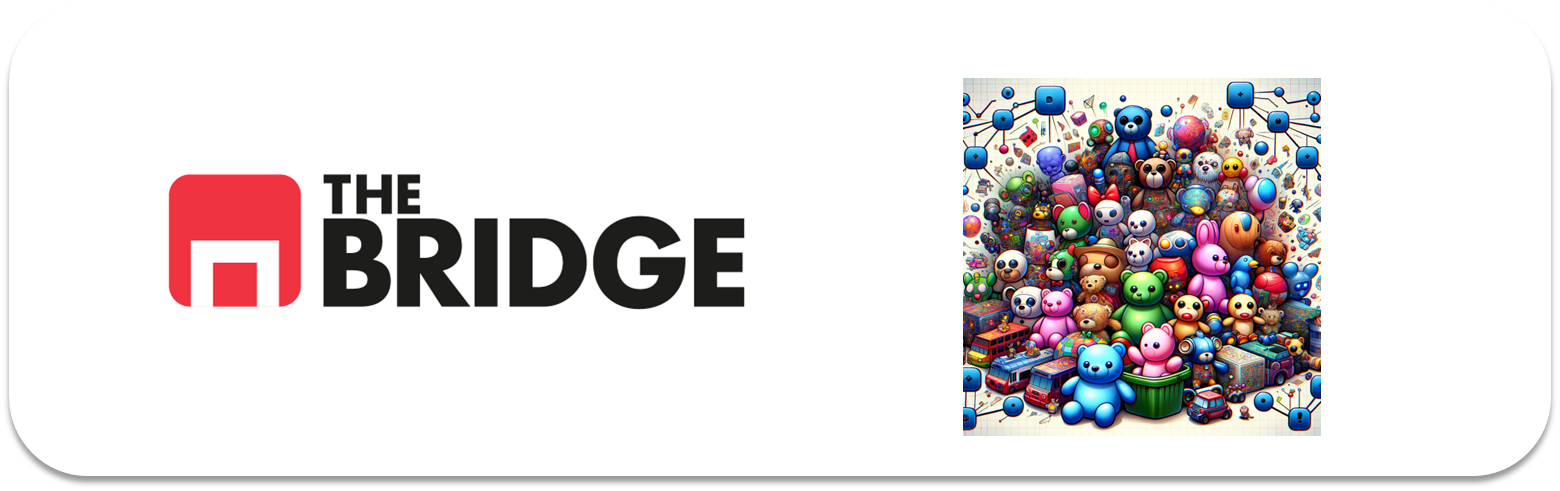

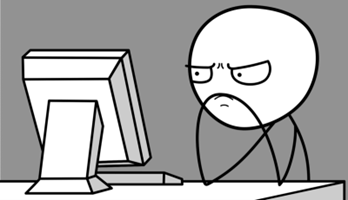

Para ejercitarte y afianzar lo aprendido sobre **K-Means**, completa los siguientes ejercicios. Recuerda que necesitarás datos que están en el directorio data que acompaña al notebook (búscalo en el repositorio de ejercicios)
  
La solución a los mismos las tienes ya, intenta no mirarlos de primeras pero no dejes de hacerlo cuando hayas terminado por si te pudieran aportar.

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import MinMaxScaler

### Entendiendo el problema de negocio

En este notebook vamos a hacer un análisis de datos tirando de clusterizaciones para evaluar si existen grupos en nuestros productos, en este caso medicamentos, y posteriormente poder etiquetarlos. Poseemos información como rating, efectividad, efectos secundarios, entre otros.

### Ejercicio 1

Importa los datos, "./data/drugLibTrain_raw.tsv", que contiene un dataset con diferentes fármacos, sus efectos y ratings de los clientes de dichos fármacos. Realiza una inspección preliminar y quita las columnas que consideres innecesarias.

In [2]:
df = pd.read_csv('./data/drugLibTrain_raw.tsv', sep = '\t', index_col = 0)
df.head()

,urlDrugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview
2202,enalapril,4,Highly Effective,Mild Side Effects,management of congestive heart failure,slowed the progression of left ventricular dys...,"cough, hypotension , proteinuria, impotence , ...","monitor blood pressure , weight and asses for ..."
3117,ortho-tri-cyclen,1,Highly Effective,Severe Side Effects,birth prevention,Although this type of birth control has more c...,"Heavy Cycle, Cramps, Hot Flashes, Fatigue, Lon...","I Hate This Birth Control, I Would Not Suggest..."
1146,ponstel,10,Highly Effective,No Side Effects,menstrual cramps,I was used to having cramps so badly that they...,Heavier bleeding and clotting than normal.,I took 2 pills at the onset of my menstrual cr...
3947,prilosec,3,Marginally Effective,Mild Side Effects,acid reflux,The acid reflux went away for a few months aft...,"Constipation, dry mouth and some mild dizzines...",I was given Prilosec prescription at a dose of...
1951,lyrica,2,Marginally Effective,Severe Side Effects,fibromyalgia,I think that the Lyrica was starting to help w...,I felt extremely drugged and dopey. Could not...,See above


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3107 entries, 2202 to 2748
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   urlDrugName        3107 non-null   object
 1   rating             3107 non-null   int64 
 2   effectiveness      3107 non-null   object
 3   sideEffects        3107 non-null   object
 4   condition          3106 non-null   object
 5   benefitsReview     3089 non-null   object
 6   sideEffectsReview  3032 non-null   object
 7   commentsReview     3095 non-null   object
dtypes: int64(1), object(7)
memory usage: 218.5+ KB


### Ejercicio 2: MiniEDA

Como es un problema no supervisado (vamos a intentar agrupar los medicamentos sin tener una referencia o target inicial), no hay split, vamos directos al miniEDA. Analiza qué variables son descartables en función de su porcentaje de cardinalidad. Es decir obten la cardinalidad y su porcentaje para cada posible feature y crea un dataset nuevo descartando las features que creas conveniente. NOTA: Como simplificación, descarta la columna con url.

In [4]:
pd.DataFrame({'Cardinalidad': df.nunique(), '% Cardinalidad': round(df.nunique() / len(df) * 100, 2)})

,Cardinalidad,% Cardinalidad
urlDrugName,502,16.16
rating,10,0.32
effectiveness,5,0.16
sideEffects,5,0.16
condition,1426,45.90
benefitsReview,3031,97.55
sideEffectsReview,2813,90.54
commentsReview,3046,98.04


In [5]:
# Cardinalidad = unique

df.describe(include = 'all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
urlDrugName,3107,502,lexapro,63,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rating,3107.0,NaN,NaN,NaN,7.006115,2.937582,1.0,5.0,8.0,9.0,10.0
effectiveness,3107,5,Highly Effective,1330,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sideEffects,3107,5,Mild Side Effects,1019,NaN,NaN,NaN,NaN,NaN,NaN,NaN
condition,3106,1426,depression,236,NaN,NaN,NaN,NaN,NaN,NaN,NaN
benefitsReview,3089,3031,none,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sideEffectsReview,3032,2813,none,112,NaN,NaN,NaN,NaN,NaN,NaN,NaN
commentsReview,3095,3046,none,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Ejercicio 3

Construye un train set (llámalo X) sólo con las features que hayas seleccionado del ejercicio anterior (es decir las que no hayas descartado como posibles features) 

In [6]:
X = df[['rating', 'effectiveness', 'sideEffects']].copy()
X.head()

,rating,effectiveness,sideEffects
2202,4,Highly Effective,Mild Side Effects
3117,1,Highly Effective,Severe Side Effects
1146,10,Highly Effective,No Side Effects
3947,3,Marginally Effective,Mild Side Effects
1951,2,Marginally Effective,Severe Side Effects


In [7]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3107 entries, 2202 to 2748
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   rating         3107 non-null   int64 
 1   effectiveness  3107 non-null   object
 2   sideEffects    3107 non-null   object
dtypes: int64(1), object(2)
memory usage: 97.1+ KB


### Ejercicio 4 

Trasforma las features que consideres necesario (categóricas y numéricas) y luego aplica el escalado que consideres necesario.

In [8]:
for col in X.select_dtypes(include = 'object').columns:
    print(df[col].value_counts())
    print('')

effectiveness
Highly Effective          1330
Considerably Effective     928
Moderately Effective       415
Ineffective                247
Marginally Effective       187
Name: count, dtype: int64

sideEffects
Mild Side Effects                1019
No Side Effects                   930
Moderate Side Effects             614
Severe Side Effects               369
Extremely Severe Side Effects     175
Name: count, dtype: int64



In [9]:
X['effectiveness'] = X['effectiveness'].map({'Ineffective': 0, 'Marginally Effective': 1, 'Moderately Effective': 2, 'Considerably Effective': 3, 'Highly Effective': 4})
X['sideEffects'] = X['sideEffects'].map({'No Side Effects': 0, 'Mild Side Effects': 1, 'Moderate Side Effects': 2, 'Severe Side Effects': 3, 'Extremely Severe Side Effects': 4})

In [10]:
minmax = MinMaxScaler()
X[X.columns] = minmax.fit_transform(X)

In [11]:
X.head()

,rating,effectiveness,sideEffects
2202,0.333333,1.00,0.25
3117,0.000000,1.00,0.75
1146,1.000000,1.00,0.00
3947,0.222222,0.25,0.25
1951,0.111111,0.25,0.75


In [12]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3107 entries, 2202 to 2748
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   rating         3107 non-null   float64
 1   effectiveness  3107 non-null   float64
 2   sideEffects    3107 non-null   float64
dtypes: float64(3)
memory usage: 97.1 KB


### Ejercicio 5: Otención de K, aproximación visual

Analiza la relación entre features (con scatter plots) una vez transformadas para comprobar si existe visualmente algún indicio del número de clústeres que podríamos estar buscando. Por otro lado este análisis nos puede hacer descartar alguna feature o generar una nueva

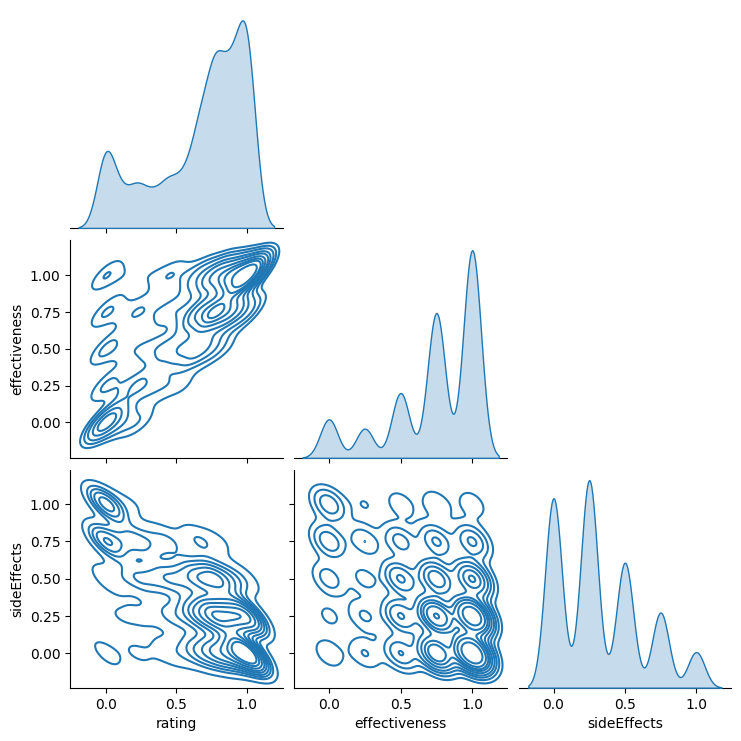

In [13]:
sns.pairplot(X, kind = 'kde', corner = True);

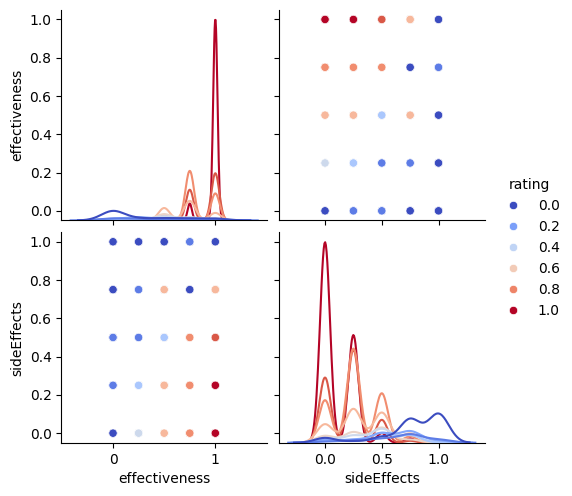

In [14]:
sns.pairplot(X, hue = 'rating', palette = 'coolwarm', diag_kws = dict(fill = False));

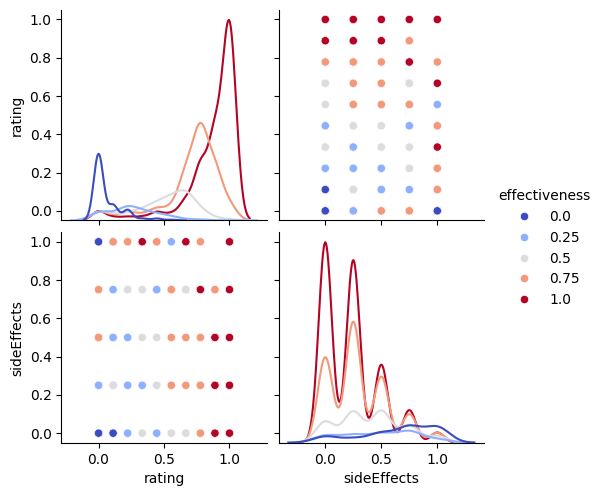

In [15]:
sns.pairplot(X, hue = 'effectiveness', palette = 'coolwarm', diag_kws = dict(fill = False));

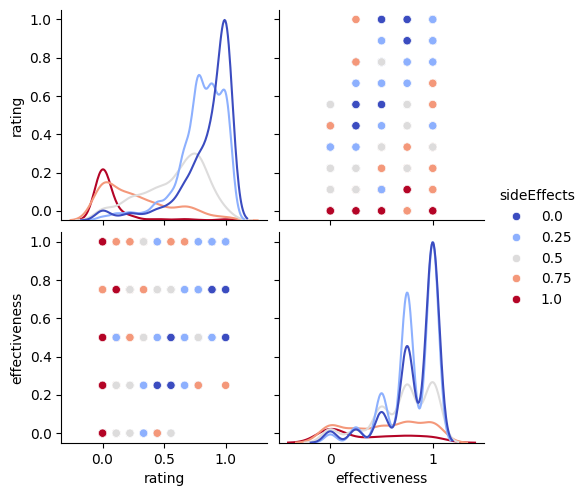

In [16]:
sns.pairplot(X, hue = 'sideEffects', palette = 'coolwarm', diag_kws=dict(fill=False));

### Ejercicio 6: Obtención de K, método del codo

Evalua diferentes valores K y escoge uno a partir del método del codo/elbow de inercia.

In [17]:
# Generación de modelos, cálculo de su inercia y guardado en diccionario
inertias = {k: KMeans(n_clusters = k).fit(X).inertia_ for k in range(1, 10)}

# Extra de la solución
df_inertias = pd.DataFrame({'k': list(inertias.keys()), 'inertia': list(inertias.values())})
df_inertias['diff'] = df_inertias['inertia'] - df_inertias['inertia'].shift(1)
df_inertias

/Users/maria/.pyenv/versions/3.12.4/lib/python3.12/site-packages/joblib/externals/loky/backend/context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[Errno 2] No such file or directory: 'sysctl'
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "/Users/maria/.pyenv/versions/3.12.4/lib/python3.12/site-packages/joblib/externals/loky/backend/context.py", line 270, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "/Users/maria/.pyenv/versions/3.12.4/lib/python3.12/subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/maria/.pyenv/versions/3.12.4/lib/python3.12/subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "/Users/maria/.pyenv/versions/3.12.4

,k,inertia,diff
0,1,893.992575,NaN
1,2,395.777929,-498.214646
2,3,300.398526,-95.379403
3,4,236.933495,-63.465031
4,5,192.455938,-44.477557
5,6,173.471808,-18.984130
6,7,139.286260,-34.185549
7,8,124.321634,-14.964625
8,9,111.075899,-13.245735


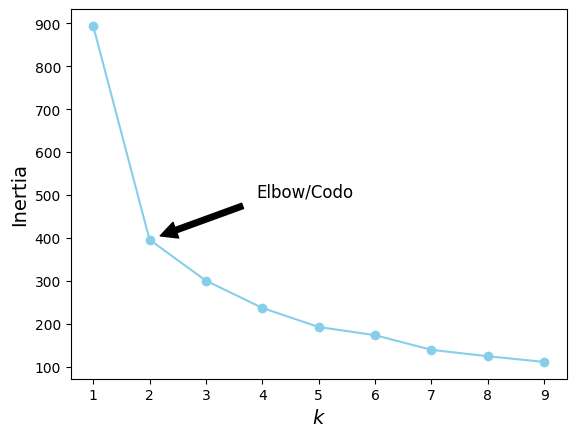

In [18]:
plt.plot(list(inertias.keys()), list(inertias.values()), 'o-', color = 'skyblue')
plt.ylabel('Inertia', fontsize = 14)
plt.xlabel('$k$', fontsize = 14)
plt.annotate('Elbow/Codo',
             xy = (2, inertias[2]),
             xytext = (0.4, 0.5),
             textcoords = 'figure fraction',
             fontsize = 12,
             arrowprops = dict(facecolor = 'black', shrink = 0.1)
            )
plt.show()

### Ejercicio 7: Obtención de K, Score de Silueta

Comprueba el ajuste de k obteniendo el k que maximiza el score de silueta y pinta un gráfico de la evolución de dicho score con k. Usa los valores de k que hayas probado en el ejercicio anterior.

In [19]:
silhouettes = {}

for k in range(2,10):
    model = KMeans(n_clusters = k).fit(X)
    silhouettes[k]= silhouette_score(X, model.labels_)
    
silhouettes

{2: 0.5317609068430345,
 3: 0.4216715251658557,
 4: 0.3386693396179719,
 5: 0.3776609561470751,
 6: 0.38314316869232146,
 7: 0.4187499257958103,
 8: 0.43589753000760095,
 9: 0.4448168463939151}

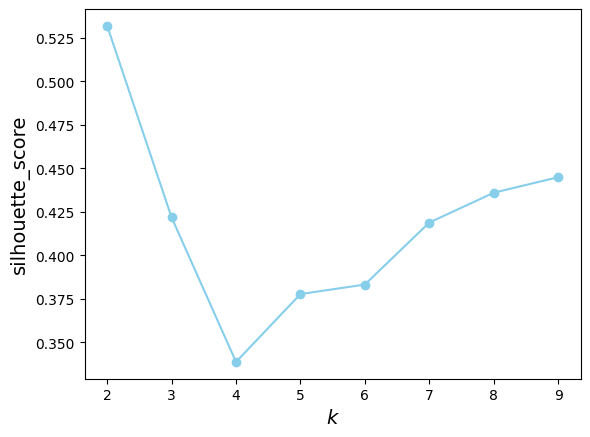

In [20]:
plt.plot(list(silhouettes.keys()), list(silhouettes.values()), 'o-', color = 'skyblue')
plt.ylabel('silhouette_score', fontsize = 14)
plt.xlabel('$k$', fontsize = 14)

plt.show()

### Ejercicio 8: Obtención de K, diagrama de silueta

Para completar el estudio de k, muestra el diagramde silueta para k = 2, 3, 4, 5 y decide con este datos y los anteriores el valor de k a probar.  
NOTA: En la realidad, podríamos probar perfectamente k=2 y k=3 y luego que "Negocio" decidiera cuál le es más útil, aquí lo completamos por practicar todo lo aprendido

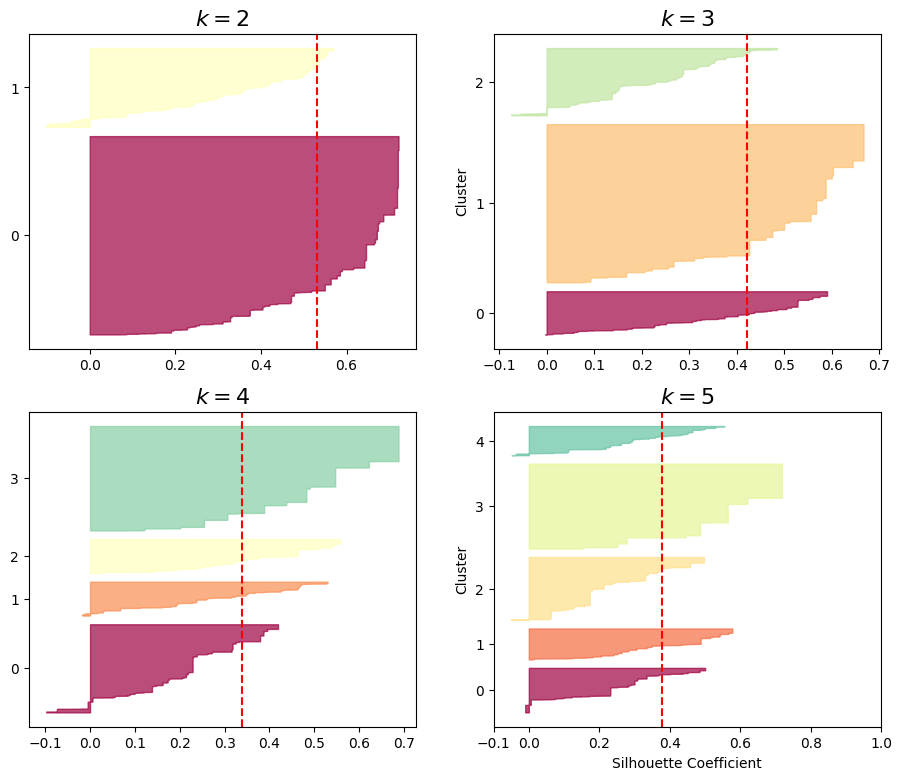

In [21]:
from matplotlib.ticker import FixedLocator, FixedFormatter

'''
La anchura de cada cuchillo representa el numero de muestras por cluster. 
Están ordenadas por su coeficiente de silhouette, por eso tiene esa forma de cuchillo. 
Cuanta más caida tenga indica que las muestras tienen un coeficiente mas disperso en ese cluster
Deberian estar todos los clusters por encima de la media.
Hay algunas líneas hacia la izda porque es el coeficiente negativo. Puntos asignados al cluster erroneo.
'''
plt.figure(figsize = (11, 9))

for k in (2, 3, 4, 5):
    plt.subplot(2, 2, k - 1)
    
    cluster = KMeans(n_clusters = k).fit(X)
    y_pred = cluster.labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs, facecolor = color, edgecolor = color, alpha = 0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel('Cluster')
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel('Silhouette Coefficient')
    else:
        plt.tick_params(labelbottom = True)

    plt.axvline(x = list(silhouettes.values())[k - 2], color = 'red', linestyle = '--')
    plt.title('$k={}$'.format(k), fontsize = 16)


plt.show()

### Ejercico 9:

En general, una diferencia entre el proceso de construcción de un modelo no supervisado y uno supervisado es que el ajuste de algunos hiperparámetros (como el número de clústeres) es anterior a la construcción del modelo. Por eso, construye un K-means para el valor (o valores) de K escogidos.

In [22]:
# k = 2
clustering_k2 = KMeans(n_clusters = 2).fit(X)

### Ejercicio 10

Vamos a comprobar resultados, analizando los valores medios y distribución de cada uno de los clústeres para el k óptimo. Si tuvieras más de un posible valor de k a probar, analiza aquí el de mayor score de silueta. Y utiliza el siguiente ejercicio para el otro. Además de hacer un describe de las features por clúster, pinta estos con un pairplot considerando sideEffects y rating como x e y (o viceversa) y el clúster como hue (color). Compara el resultado con los clústeres sugeridos en el ejercicio 5.

In [23]:
X['cluster_k2'] = clustering_k2.labels_
X['cluster_k2'].value_counts(True)

cluster_k2
1    0.715481
0    0.284519
Name: proportion, dtype: float64

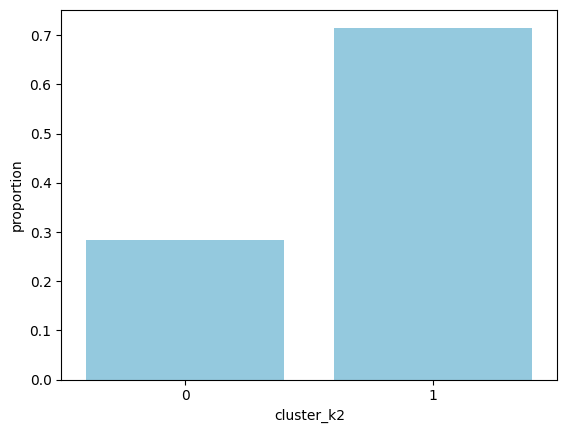

In [24]:
sns.countplot(X, x = X['cluster_k2'], stat = 'proportion', color = 'skyblue');

In [25]:
X.groupby('cluster_k2').describe().T

cluster_k2                    0            1
rating        count  884.000000  2223.000000
              mean     0.224233     0.843555
              std      0.215051     0.146161
              min      0.000000     0.000000
              25%      0.000000     0.777778
              50%      0.222222     0.888889
              75%      0.444444     1.000000
              max      1.000000     1.000000
effectiveness count  884.000000  2223.000000
              mean     0.393665     0.869208
              std      0.320372     0.164715
              min      0.000000     0.250000
              25%      0.000000     0.750000
              50%      0.500000     1.000000
              75%      0.750000     1.000000
              max      1.000000     1.000000
sideEffects   count  884.000000  2223.000000
              mean     0.628394     0.206028
              std      0.279899     0.198032
              min      0.000000     0.000000
              25%      0.500000     0.000000
              50%      0.750000     0.250000
              75%      0.750000     0.250000
              max      1.000000     1.000000

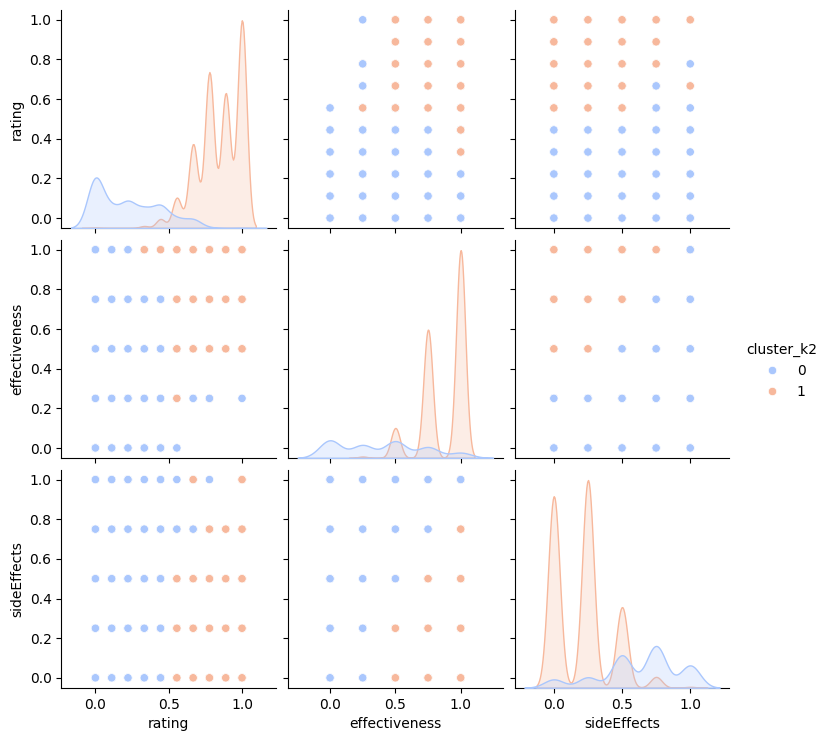

In [26]:
sns.pairplot(X, hue = 'cluster_k2', palette = 'coolwarm');

### Ejercicio 11, EXTRA: Más valores de K

Repite el análisis del ejercicio 10 para un K diferente pero que consideres que tiene sentido aplicar.

In [27]:
# k = 3

clustering_k3 = KMeans(n_clusters = 3).fit(X)
X['cluster_k3'] = clustering_k3.labels_
X

,rating,effectiveness,sideEffects,cluster_k2,cluster_k3
2202,0.333333,1.00,0.25,1,0
3117,0.000000,1.00,0.75,0,1
1146,1.000000,1.00,0.00,1,0
3947,0.222222,0.25,0.25,0,2
1951,0.111111,0.25,0.75,0,2
...,...,...,...,...,...
1039,1.000000,1.00,0.25,1,0
3281,0.000000,0.00,1.00,0,2
1664,0.111111,0.25,0.50,0,2
2621,0.777778,0.75,0.25,1,0


In [28]:
X['cluster_k3'].value_counts(True)

cluster_k3
0    0.715481
1    0.148053
2    0.136466
Name: proportion, dtype: float64

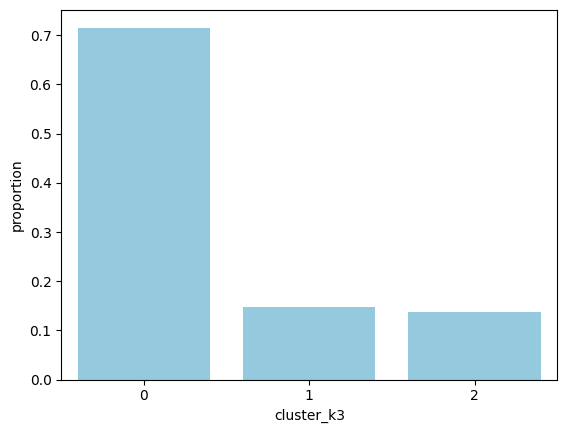

In [29]:
sns.countplot(X, x = X['cluster_k3'], stat = 'proportion', color = 'skyblue');

In [30]:
X.groupby('cluster_k3')[['rating', 'effectiveness', 'sideEffects']].describe().T

cluster_k3                     0           1           2
rating        count  2223.000000  460.000000  424.000000
              mean      0.843555    0.305556    0.136006
              std       0.146161    0.224645    0.163659
              min       0.000000    0.000000    0.000000
              25%       0.777778    0.111111    0.000000
              50%       0.888889    0.333333    0.111111
              75%       1.000000    0.444444    0.222222
              max       1.000000    1.000000    0.666667
effectiveness count  2223.000000  460.000000  424.000000
              mean      0.869208    0.659783    0.104953
              std       0.164715    0.187467    0.124718
              min       0.250000    0.250000    0.000000
              25%       0.750000    0.500000    0.000000
              50%       1.000000    0.500000    0.000000
              75%       1.000000    0.750000    0.250000
              max       1.000000    1.000000    0.500000
sideEffects   count  2223.000000  460.000000  424.000000
              mean      0.206028    0.672283    0.580778
              std       0.198032    0.214070    0.330827
              min       0.000000    0.000000    0.000000
              25%       0.000000    0.500000    0.250000
              50%       0.250000    0.750000    0.750000
              75%       0.250000    0.750000    0.750000
              max       1.000000    1.000000    1.000000

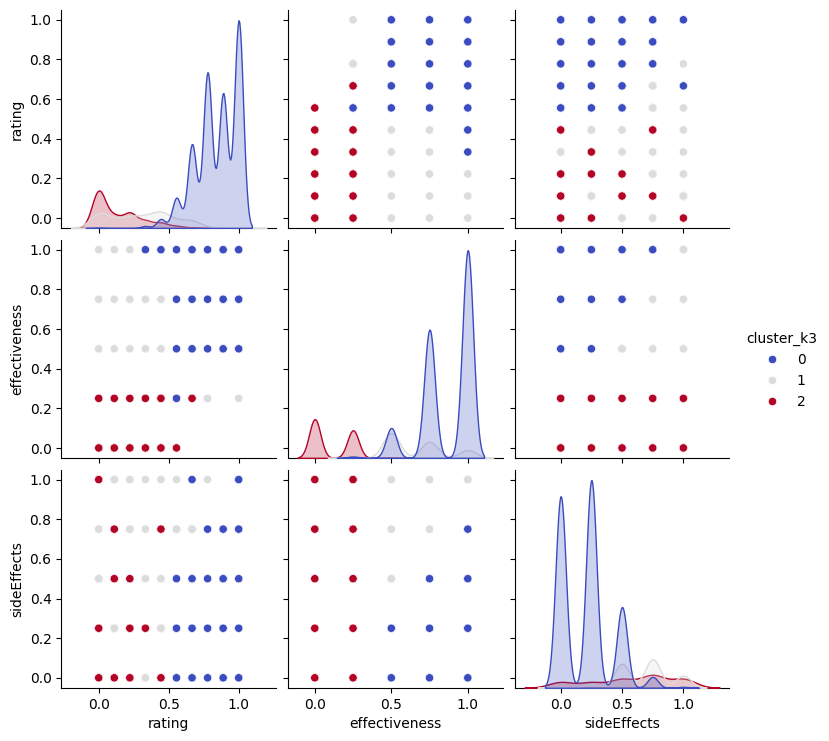

In [31]:
sns.pairplot(X[['rating', 'effectiveness', 'sideEffects', 'cluster_k3']], hue = 'cluster_k3', palette = 'coolwarm');